In [1]:
  import sys
  sys.path.insert(0, '/content/')

In [18]:
from scipy.stats import skew, kurtosis
from DataGenerator import DataGenerator
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt

GAMMA_LAMBDA_0 = np.sqrt(0.5)  # θ0
WEIBULL_LAMBDA_0 = 1 / np.sqrt(10)  # υ0
def compute_graph_features(G):
    if G.number_of_nodes() == 0:
        return [0]*10

    degrees = [d for _, d in G.degree()]
    min_deg = min(degrees)
    mean_deg = np.mean(degrees)
    max_deg = max(degrees)

    try:
        global_clust = nx.average_clustering(G)
    except:
        global_clust = 0

    num_cc = nx.number_connected_components(G)
    if num_cc > 0:
        largest_cc = max(nx.connected_components(G), key=len)
        largest_cc_size = len(largest_cc)
    else:
        largest_cc_size = 0

    density = nx.density(G)

    try:
        skew_deg = skew(degrees)
    except:
        skew_deg = 0

    try:
        kurt_deg = kurtosis(degrees, fisher=False)
    except:
        kurt_deg = 0

    try:
        assort = nx.degree_assortativity_coefficient(G)
    except:
        assort = 0

    return [min_deg, mean_deg, max_deg, global_clust, num_cc,
            largest_cc_size, density, skew_deg, kurt_deg, assort]

In [12]:
def build_knn_graph(data, k):
    data = data.reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    adj = nbrs.kneighbors_graph(data).toarray()
    adj = np.minimum(adj + adj.T, 1)
    np.fill_diagonal(adj, 0)
    return nx.from_numpy_array(adj)

In [6]:
def generate_dataset(dgen, n, num_samples=1000, k=3):
    features_names = [
        'min_degree', 'mean_degree', 'max_degree', 'global_clustering',
        'num_cc', 'largest_cc_size', 'density', 'skewness_degree',
        'kurtosis_degree', 'assortativity'
    ]

    X = []
    y = []

    # Generate H0 samples (Gamma)
    for _ in range(num_samples):
        data = dgen.generate_gamma(n)
        G = build_knn_graph(data, k)
        feats = compute_graph_features(G)
        X.append(feats)
        y.append(0)

    # Generate H1 samples (Weibull)
    for _ in range(num_samples):
        data = dgen.generate_weibull(n)
        G = build_knn_graph(data, k)
        feats = compute_graph_features(G)
        X.append(feats)
        y.append(1)

    return np.array(X), np.array(y), features_names

In [7]:
from sklearn.ensemble import RandomForestClassifier

def analyze_feature_importance(X, y, feature_names, n):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    importances = clf.feature_importances_

    plt.figure(figsize=(10, 6))
    indices = np.argsort(importances)[::-1]
    plt.title(f"Feature Importance (n={n})")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

    return importances

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def evaluate_classifiers(X, y):
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=10000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC(kernel='rbf', probability=True),
        "KNN": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier()
    }

    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = {}

    for name, clf in classifiers.items():
        scores = cross_validate(
            clf, X, y, cv=5, scoring=metrics,
            return_train_score=False, n_jobs=-1
        )
        results[name] = {
            metric: (np.mean(scores[f'test_{metric}']),
                     np.std(scores[f'test_{metric}']))
            for metric in metrics
        }

    return results

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def evaluate_errors(clf, X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    alpha_error = fp / (fp + tn)  # Type I error (false positive)
    beta_error = fn / (fn + tp)  # Type II error (false negative)
    power = 1 - beta_error       # Power

    return alpha_error, power

In [20]:
import pandas as pd
import seaborn as sns


def analyze_metric_variance(results):
    """Анализ дисперсии метрик качества с раздельной визуализацией"""
    # Создаем структуру данных для анализа
    metrics_data = []
    classifiers = list(results[list(results.keys())[0]].keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    for n in results.keys():
        for clf in classifiers:
            for metric in metrics:
                mean, std = results[n][clf][metric]
                metrics_data.append({
                    'n': n,
                    'classifier': clf,
                    'metric': metric,
                    'mean': mean,
                    'std': std,
                    'cv': std / mean * 100  # Коэффициент вариации
                })

    df = pd.DataFrame(metrics_data)

    # 1. Графики средних значений с доверительными интервалами
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        metric_df = df[df['metric'] == metric]
        sns.lineplot(data=metric_df, x='n', y='mean', hue='classifier',
                     style='classifier', markers=True, dashes=False,
                     markersize=8, err_style='bars', errorbar=('ci', 95))
        plt.title(f'Средние значения {metric} с 95% ДИ')
        plt.xlabel('Размер выборки (n)')
        plt.ylabel(metric.capitalize())
        plt.grid(alpha=0.3)
        if i == len(metrics):
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            plt.legend().remove()
    plt.tight_layout()
    plt.show()

    # 2. Графики стандартного отклонения
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        metric_df = df[df['metric'] == metric]
        sns.lineplot(data=metric_df, x='n', y='std', hue='classifier',
                     style='classifier', markers=True, dashes=False, markersize=8)
        plt.title(f'Стандартное отклонение {metric}')
        plt.xlabel('Размер выборки (n)')
        plt.ylabel(f'Std({metric})')
        plt.grid(alpha=0.3)
        if i == len(metrics):
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            plt.legend().remove()
    plt.tight_layout()
    plt.show()

    # 3. Графики коэффициента вариации
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(3, 2, i)
        metric_df = df[df['metric'] == metric]
        sns.lineplot(data=metric_df, x='n', y='cv', hue='classifier',
                     style='classifier', markers=True, dashes=False, markersize=8)
        plt.title(f'Коэффициент вариации {metric}')
        plt.xlabel('Размер выборки (n)')
        plt.ylabel(f'CV({metric}), %')
        plt.axhline(y=10, color='r', linestyle='--', alpha=0.5)
        plt.grid(alpha=0.3)
        if i == len(metrics):
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            plt.legend().remove()
    plt.tight_layout()
    plt.show()

    # 4. Сравнение дисперсий классификаторов при разных n
    n_values = sorted(results.keys())
    plt.figure(figsize=(15, 8))
    for i, n in enumerate(n_values, 1):
        plt.subplot(1, len(n_values), i)
        n_df = df[df['n'] == n]
        sns.barplot(data=n_df, x='metric', y='std', hue='classifier')
        plt.title(f'Сравнение std метрик (n={n})')
        plt.xlabel('Метрика')
        plt.ylabel('Стандартное отклонение')
        plt.ylim(0, n_df['std'].max() * 1.1)
        plt.grid(axis='y', alpha=0.3)
        if i == len(n_values):
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            plt.legend().remove()
    plt.tight_layout()
    plt.show()

    # 5. Сводные таблицы
    print("\nСредние значения метрик:")
    mean_table = df.groupby(['classifier', 'metric', 'n'])['mean'].mean().unstack()
    print(mean_table)

    print("\nСтандартные отклонения:")
    std_table = df.groupby(['classifier', 'metric', 'n'])['std'].mean().unstack()
    print(std_table)

    return df



Research for n = 25


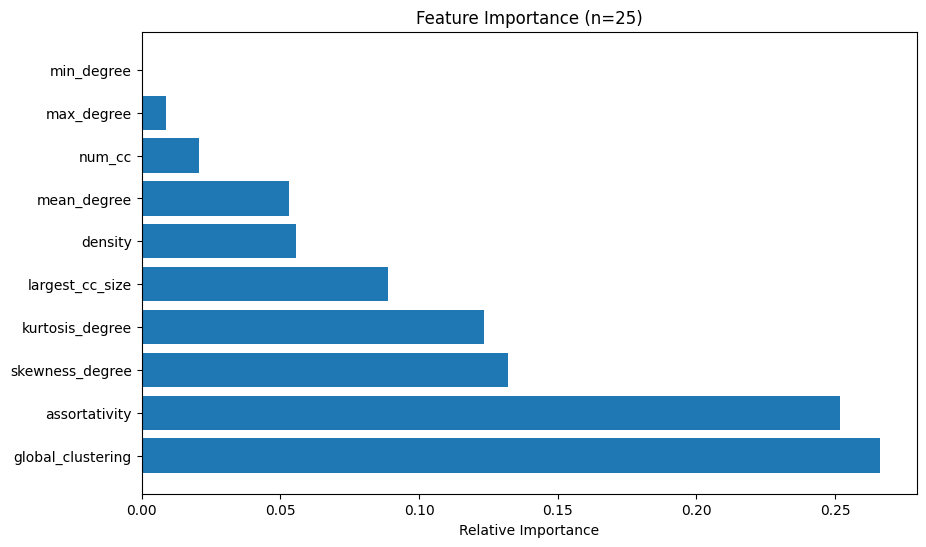


Type I Error: 0.3767
Statistical Power: 0.5400

Research for n = 100


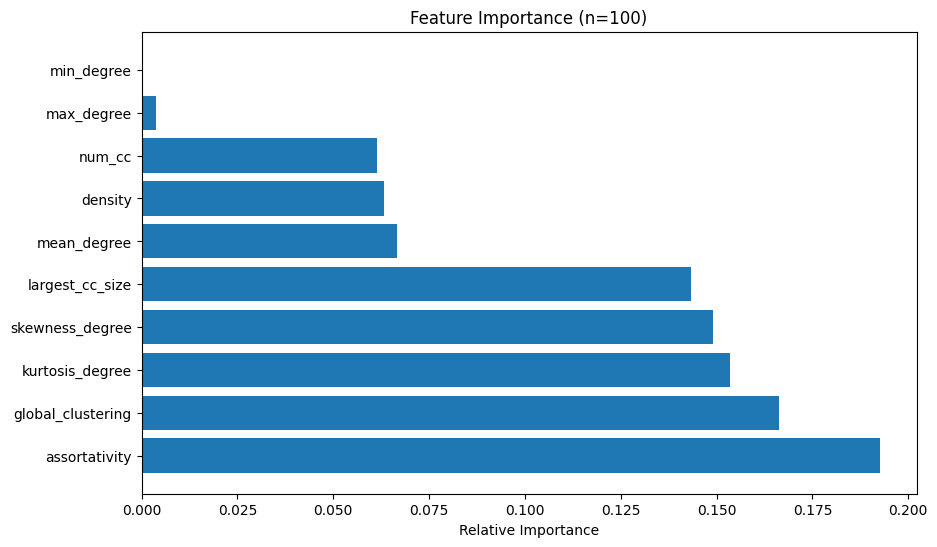


Type I Error: 0.5433
Statistical Power: 0.4833

Research for n = 500


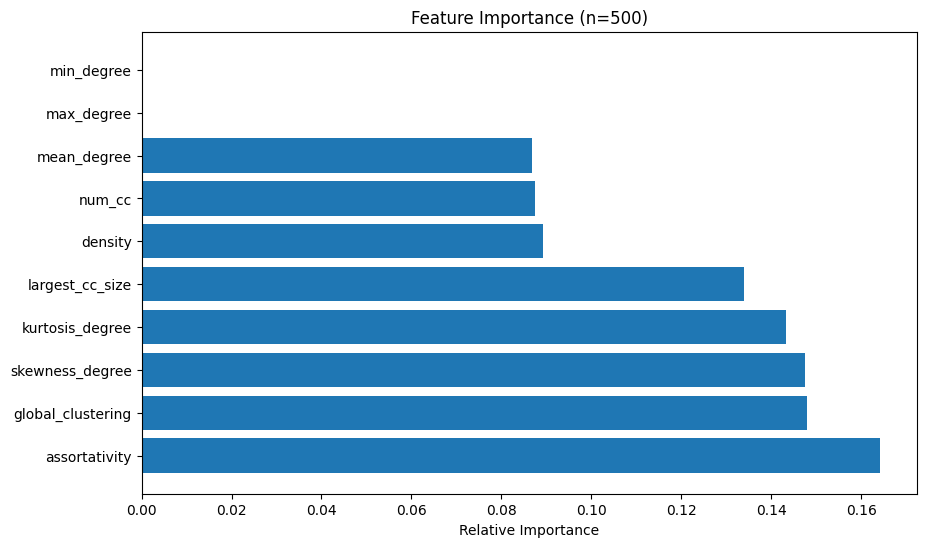


Type I Error: 0.4500
Statistical Power: 0.4567


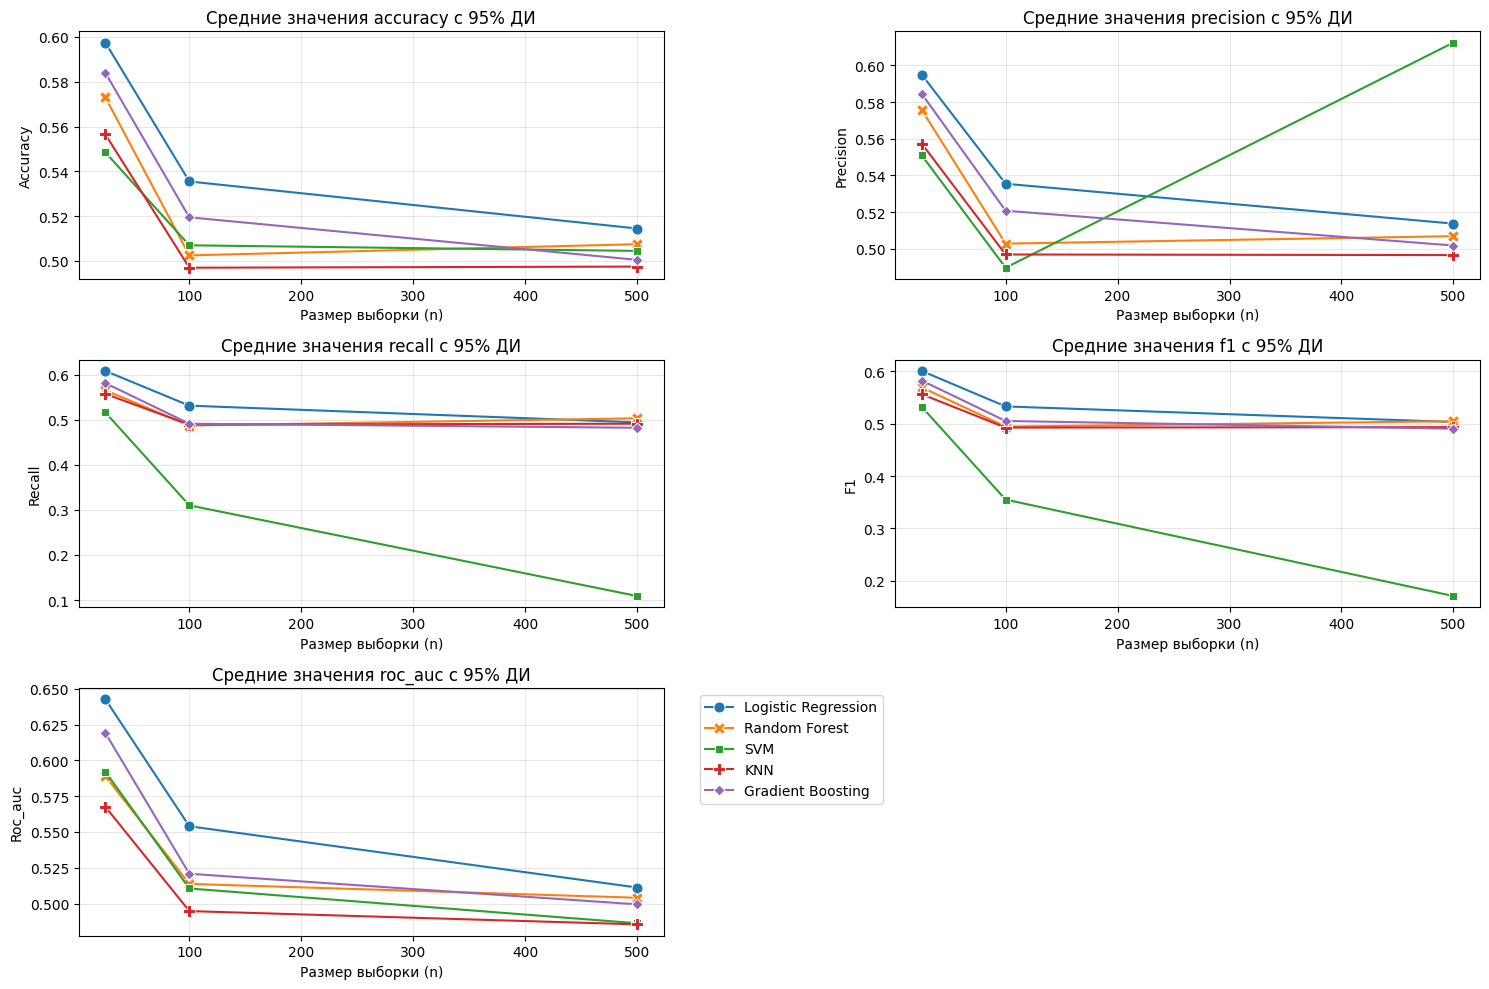

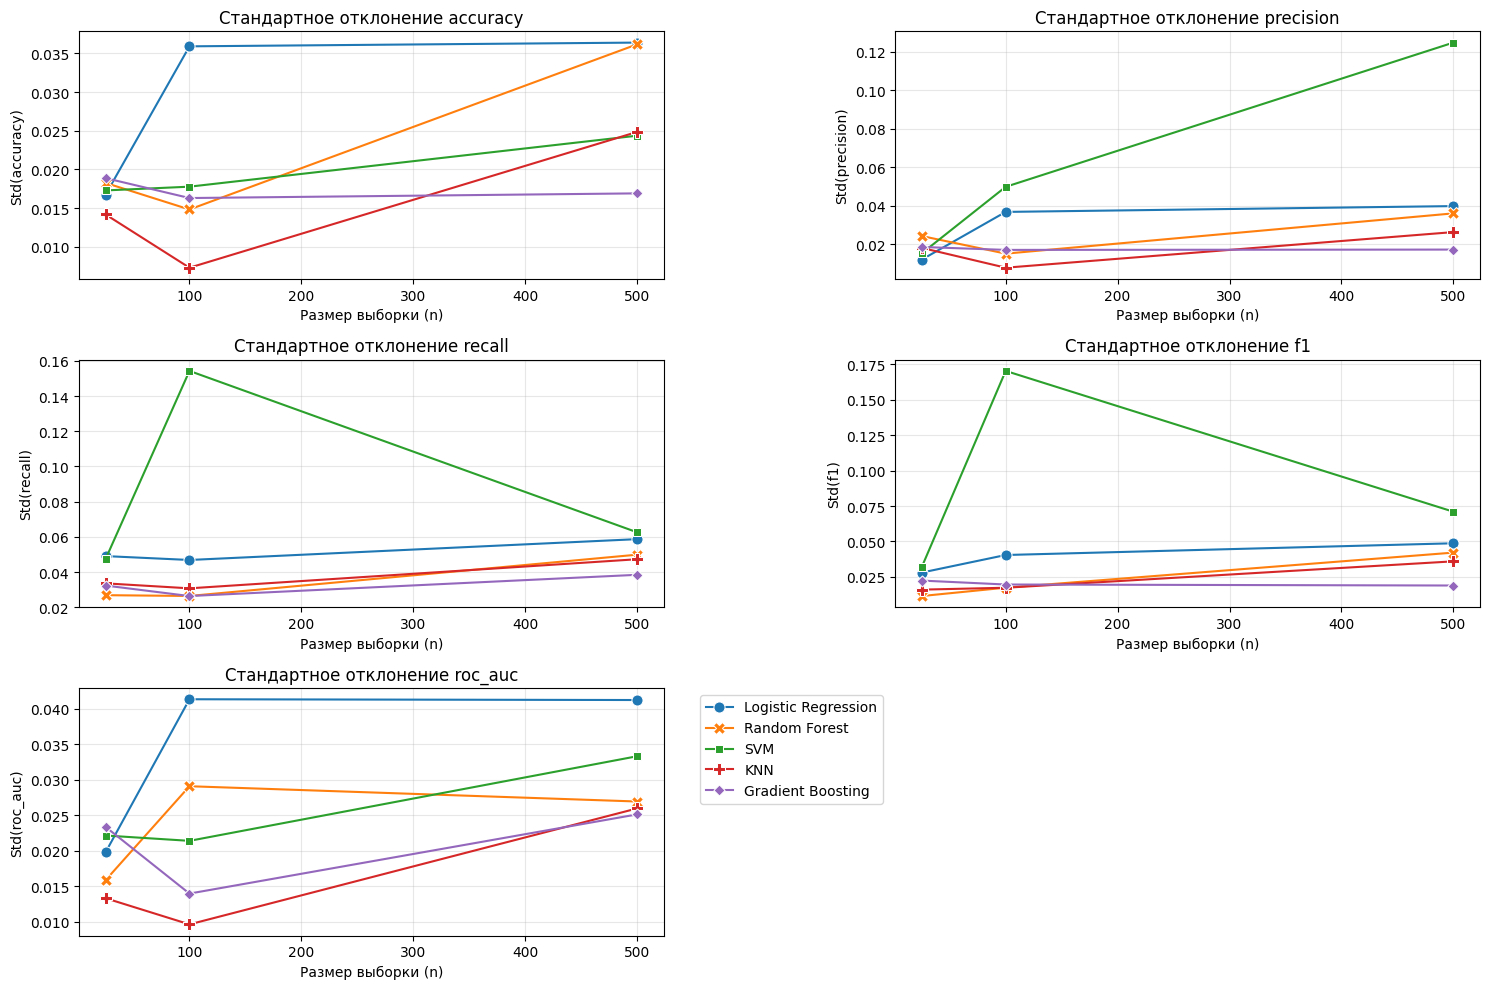

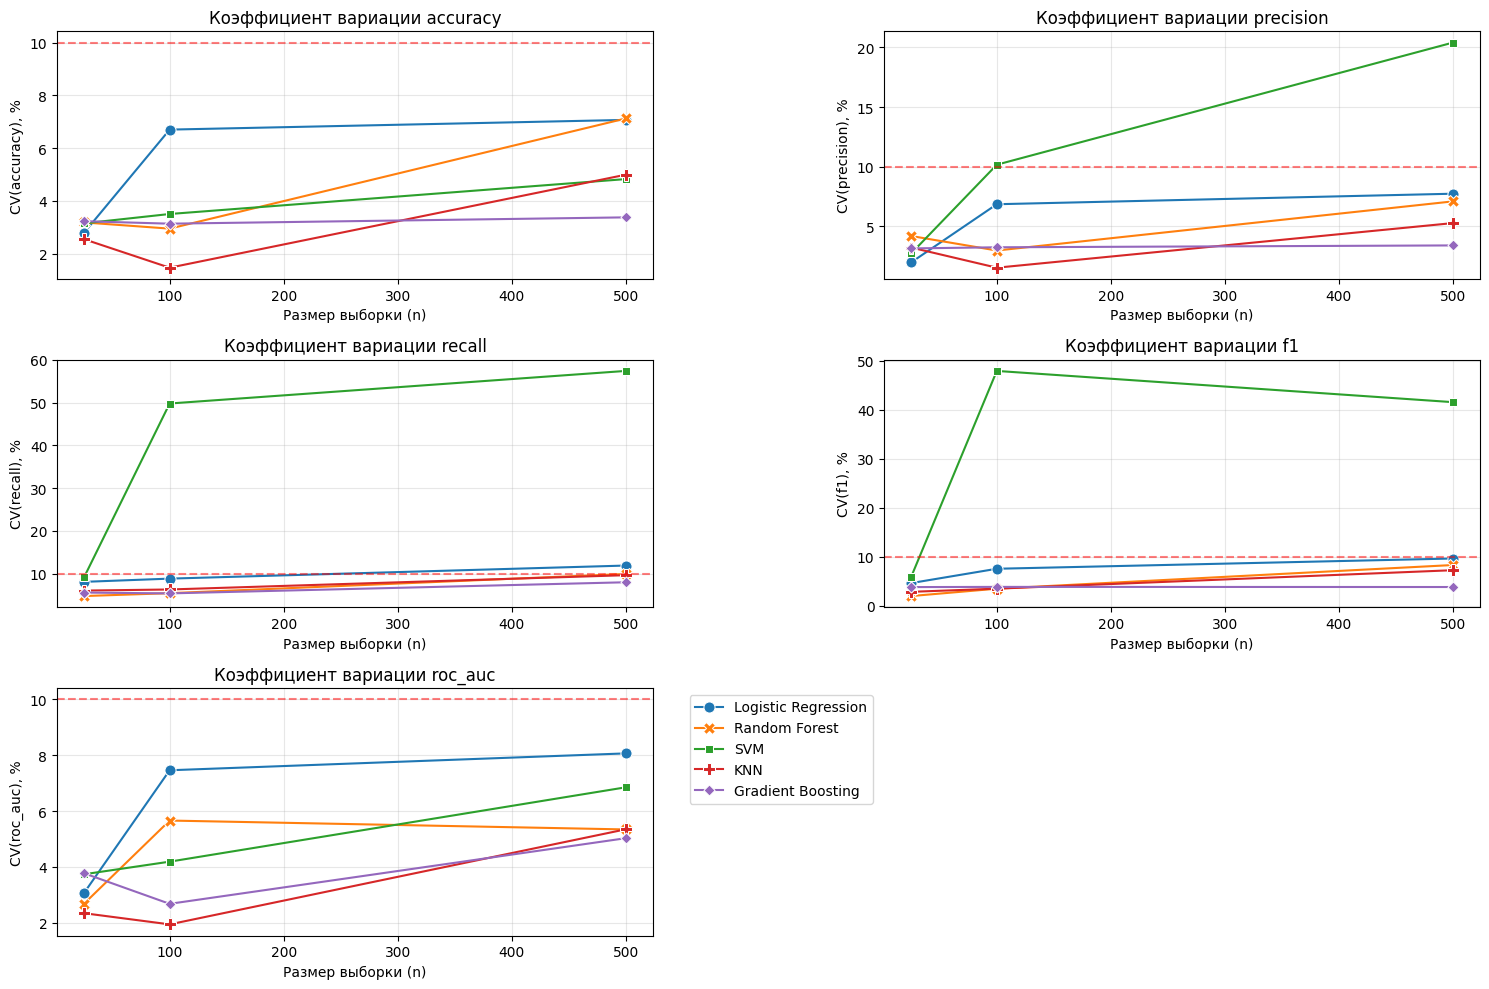

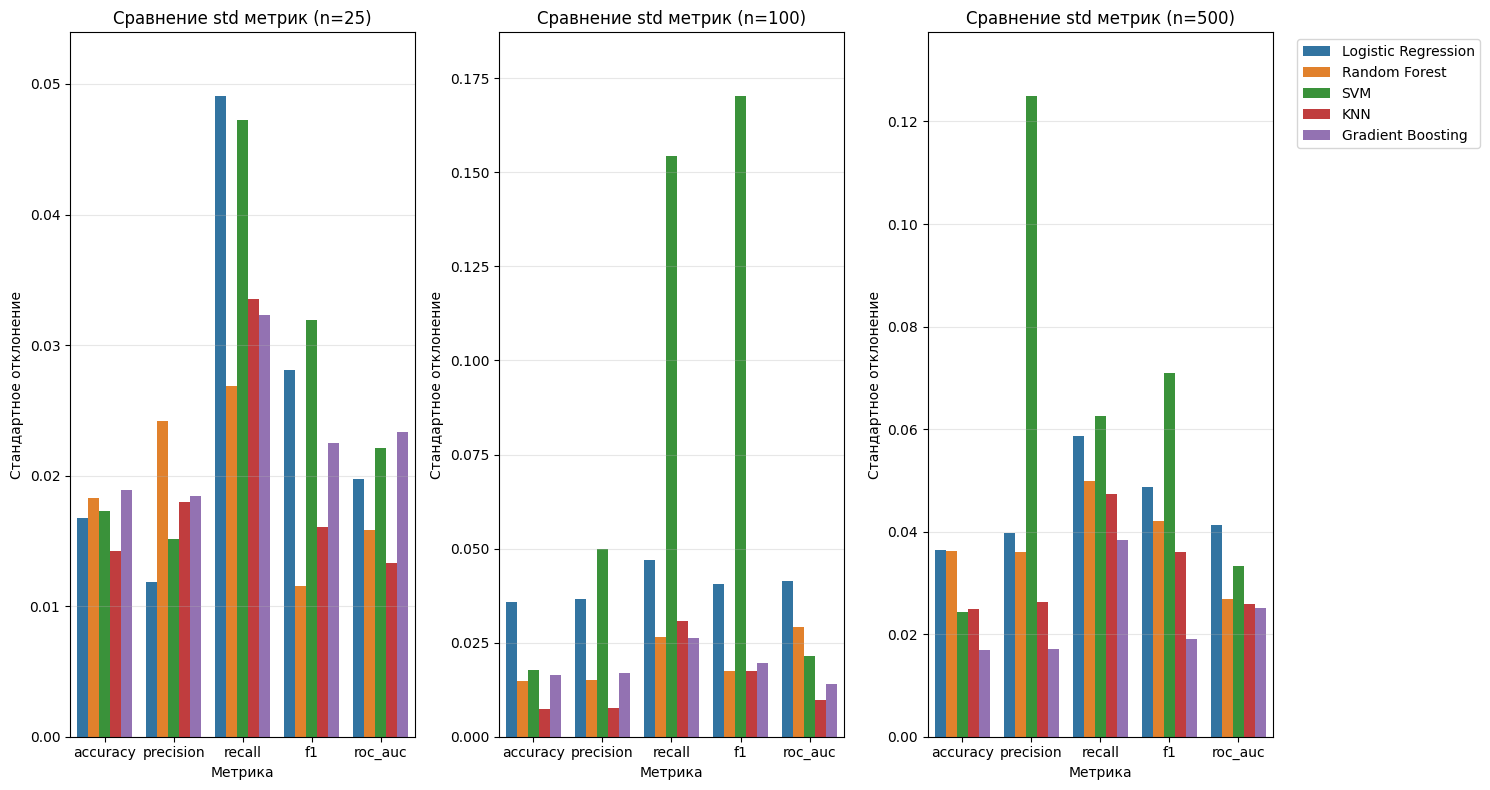


Средние значения метрик:
n                                   25        100       500
classifier          metric                                 
Gradient Boosting   accuracy   0.584000  0.519500  0.500500
                    f1         0.582445  0.505178  0.490404
                    precision  0.584594  0.520724  0.501744
                    recall     0.581000  0.491000  0.482000
                    roc_auc    0.619185  0.520810  0.499420
KNN                 accuracy   0.556500  0.497000  0.497500
                    f1         0.556333  0.492493  0.493392
                    precision  0.557388  0.496849  0.496518
                    recall     0.557000  0.489000  0.491000
                    roc_auc    0.567630  0.494718  0.485428
Logistic Regression accuracy   0.597500  0.535500  0.514500
                    f1         0.600786  0.532962  0.503223
                    precision  0.595050  0.535441  0.513687
                    recall     0.608000  0.531000  0.494000
              

In [21]:
if __name__ == "__main__":
    dgen = DataGenerator(GAMMA_LAMBDA_0, WEIBULL_LAMBDA_0)
    ns = [25, 100, 500]
    k = 3
    num_samples = 1000

    results = {}
    feature_importances = {}

    for n in ns:
        print(f"\n{'='*50}")
        print(f"Research for n = {n}")
        print(f"{'='*50}")

        # Generate dataset
        X, y, feature_names = generate_dataset(dgen, n, num_samples, k)

        # Feature importance analysis
        importances = analyze_feature_importance(X, y, feature_names, n)
        feature_importances[n] = importances

        # Classifier comparison
        results[n] = evaluate_classifiers(X, y)

        # Evaluate errors for best classifier
        best_clf = RandomForestClassifier(n_estimators=100)
        alpha_error, power = evaluate_errors(best_clf, X, y)

        print(f"\nType I Error: {alpha_error:.4f}")
        print(f"Statistical Power: {power:.4f}")

    # Анализ дисперсии метрик
    variance_df = analyze_metric_variance(results)
